In [11]:
# %matplotlib widget

import os
import pandas as pd
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import contextlib

# 1. Preprocessing


In [100]:
ravdess_data = "data/RAVDESS/Speech/"

In [12]:
def extract_labels(file_name:str)->int:
    parts = file_name.split('-')
    emotion = int(parts[2])  # Emotion is the third part
    return emotion

def label_to_emotion(label:int)->str:
    if label == 1:
        return "neutral"
    elif label == 2:
        return "calm"
    elif label == 3:
        return "happy"
    elif label == 4:
        return "sad"
    elif label == 5:
        return "angry"
    elif label == 6:
        return "fearful"
    elif label == 7:
        return "disgust"
    elif label == 8:
        return "surprised"
    else:
        return "unknown"

def create_dataframe(directory:str)->pd.DataFrame:
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                label = extract_labels(file)
                emotion = label_to_emotion(label)
                data.append({"FilePath": file_path, "Emotion": emotion, "Label": label})
    df = pd.DataFrame(data)
    return df

In [105]:
dataframe = create_dataframe(ravdess_data)

In [75]:
dataframe.head()

,FilePath,Emotion,Label
0,data/RAVDESS/Speech/Actor_16/03-01-05-01-02-01...,angry,5
1,data/RAVDESS/Speech/Actor_16/03-01-06-01-02-02...,fearful,6
2,data/RAVDESS/Speech/Actor_16/03-01-06-02-01-02...,fearful,6
3,data/RAVDESS/Speech/Actor_16/03-01-05-02-01-01...,angry,5
4,data/RAVDESS/Speech/Actor_16/03-01-07-01-01-01...,disgust,7


In [76]:
print(dataframe.Emotion.value_counts())


Emotion
angry        192
fearful      192
disgust      192
sad          192
surprised    192
happy        192
calm         192
neutral       96
Name: count, dtype: int64


# 2. Data Visualisation and Exploration

In [7]:
dataframe.count()

FilePath    1440
Emotion     1440
Label       1440
dtype: int64

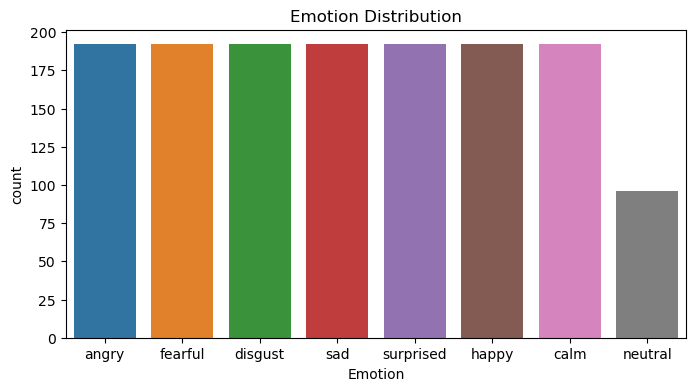

In [106]:
plt.figure(figsize=(8, 4))
sns.countplot(data=dataframe, x="Emotion")
plt.title("Emotion Distribution")
plt.show()

**Check the sampling rate of one random file to make sure it is the same as the one mentioned on the database website.**

In [107]:
sampling_rate = 0
with contextlib.closing(wave.open(dataframe.FilePath[6], 'r')) as wav_file:
    sampling_rate = wav_file.getframerate()
    print(f"Sampling rate: {sampling_rate} Hz")

Sampling rate: 48000 Hz


In [108]:
def load_audio(file_path:str)-> np.ndarray:
    audio, _ = librosa.load(file_path, sr=sampling_rate)
    return audio

In [109]:
def plot_audio(audio:np.ndarray):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sampling_rate)
    plt.grid()
    plt.show()

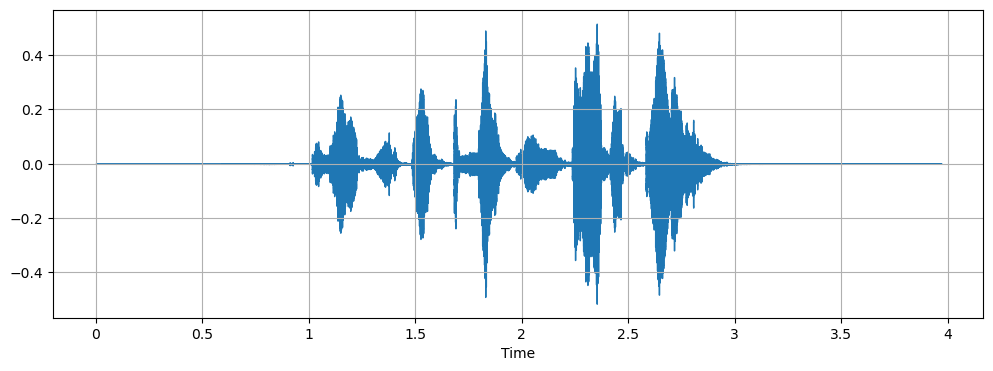

In [110]:
test_audio = load_audio(dataframe.FilePath[3])
plot_audio(test_audio)



# Data augmentation

In [111]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate:float=0.8):
    return librosa.effects.time_stretch(data, rate = rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor:bool=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [112]:
import numpy as np
import librosa

def augment_data(data, sampling_rate):
    augmentations = [
        lambda x: noise(x),
        lambda x: stretch(x, rate=np.random.uniform(0.8, 1.2)),
        lambda x: shift(x),
        lambda x: pitch(x, sampling_rate, pitch_factor=np.random.uniform(0.5, 1.5))
    ]
    augmented_data = data
    for augmentation in augmentations:
        if np.random.rand() < 0.5:  # Apply each augmentation with 50% probability
            augmented_data = augmentation(augmented_data)
    return augmented_data


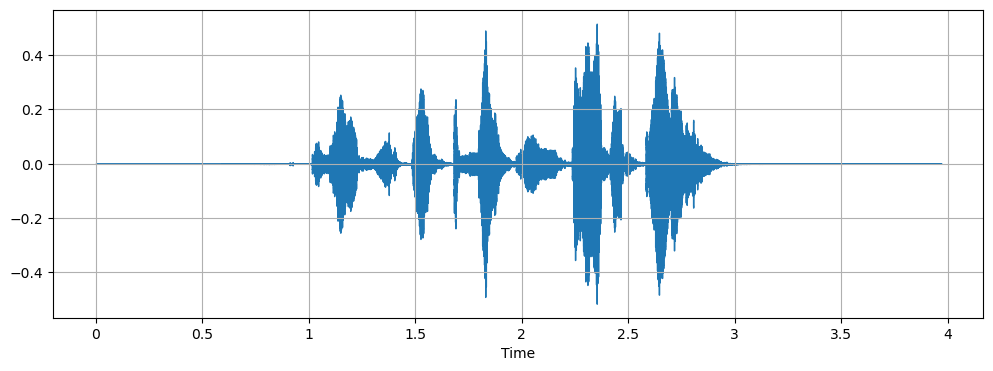

In [113]:
import IPython.display as ipd
from IPython.display import Audio

test = load_audio(dataframe.FilePath[3])
plot_audio(test)
ipd.Audio(test,rate=sampling_rate)


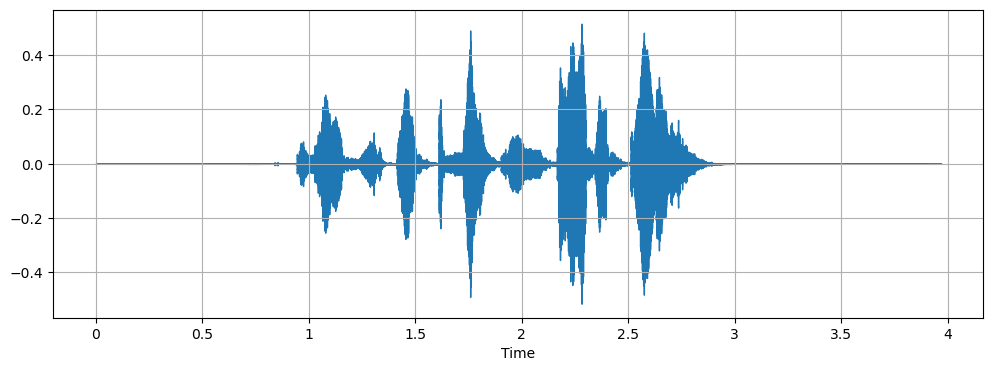

In [114]:
augmented_test = augment_data(test, sampling_rate)
plot_audio(augmented_test)
ipd.Audio(augmented_test,rate=sampling_rate)

# 3. Feature Extraction

### 3.1 Mel-Frequency Cepstral Coefficients (MFCCs)

In [115]:
def extract_mfcc(audio_path:str, sr:float=48000, n_mfcc:int=20,show_plot:bool=False,data:np.ndarray=None)->np.ndarray:
    audio = load_audio(audio_path) if data is None else data
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    if show_plot:
        librosa.display.specshow(mfcc, x_axis='time')
        plt.ylabel('MFCC')
        plt.colorbar()  
    return np.mean(mfcc.T, axis=0) 

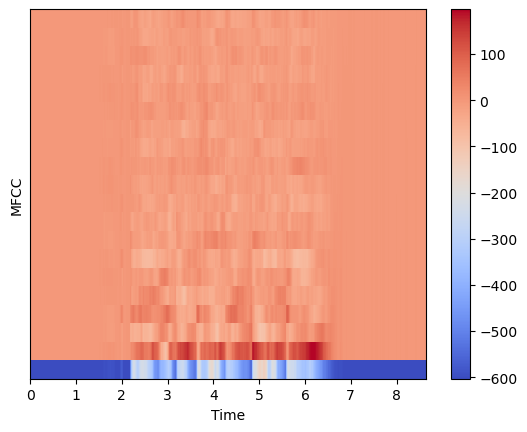

In [116]:
mfcc = extract_mfcc(dataframe.FilePath[3],show_plot=True)


In [82]:
mfcc.shape

(20,)

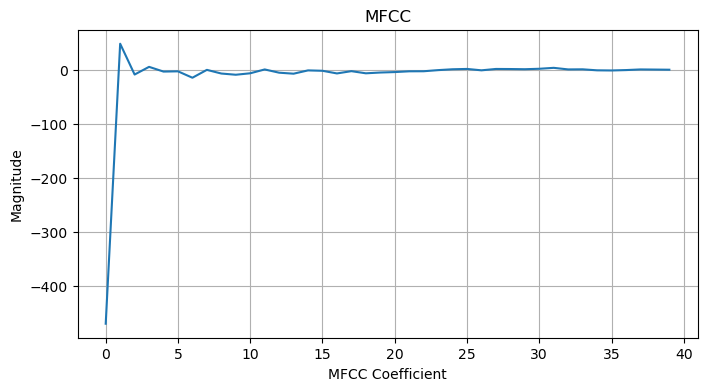

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(mfcc)
plt.title("MFCC")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

### 3.2 Log-Mel Spectrogram

In [117]:
def extract_logmel(audio_path:str, sr:float=48000, n_mels:int=128,show_plot:bool=False, data:np.ndarray=None)->np.ndarray:
    audio= load_audio(audio_path) if data is None else data
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel_spectrogram)
    if show_plot:
        plt.figure(figsize=(8, 4))
        librosa.display.specshow(logmel, y_axis='mel', sr=sampling_rate, x_axis='time');
        print(logmel.shape)
        plt.title('Mel Spectrogram ')
        plt.colorbar(format='%+2.0f dB')

    return logmel.mean(axis=1)  # Mean across time frames


(128, 373)
(128, 304)


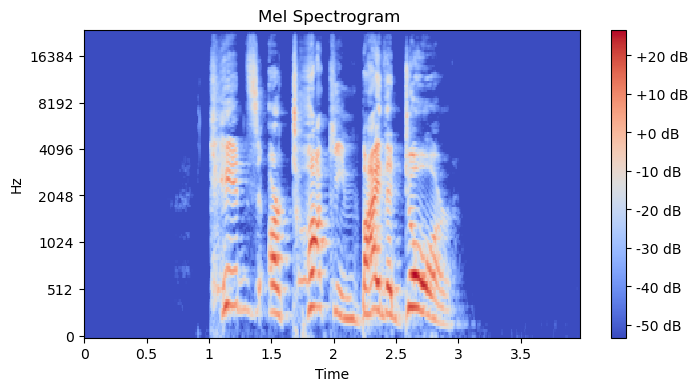

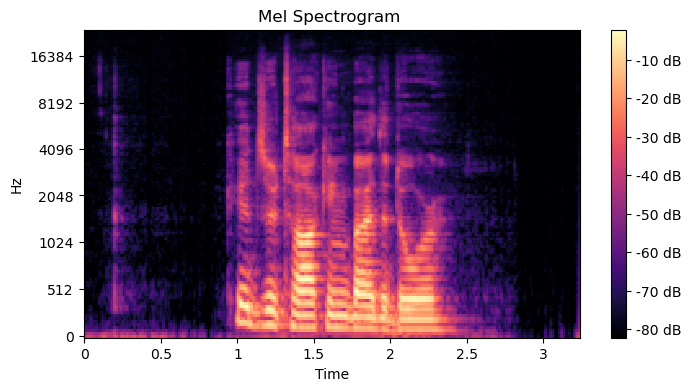

In [84]:
logmel = extract_logmel(dataframe.FilePath[3],show_plot=True)
logmel3 = extract_logmel(dataframe.FilePath[300],show_plot=True)

In [85]:
logmel.shape

(128,)

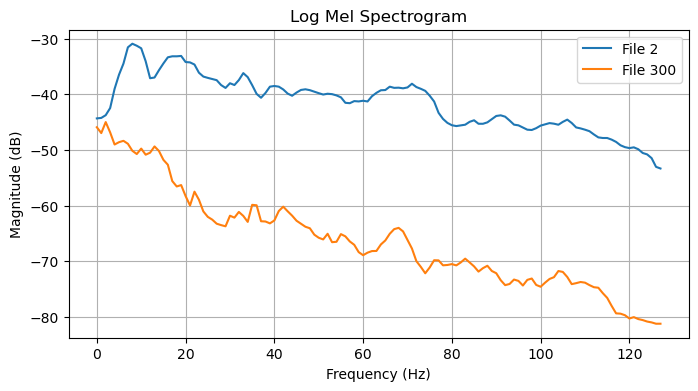

In [86]:
plt.figure(figsize=(8, 4))
plt.plot(logmel, label="File 2")
plt.plot(logmel3, label="File 300")
plt.title("Log Mel Spectrogram")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid()
plt.show()

### 3.2.1 Chromagram

In [118]:
def extract_chromagram(audio_path:str, sr:float=48000, n_chroma:int=12,show_plot:bool=False, data:np.ndarray=None)->np.ndarray:
    audio= load_audio(audio_path) if data is None else data
    chromagram = librosa.feature.chroma_stft(y=audio, sr=sr, n_chroma=n_chroma)
    if show_plot:
        plt.figure(figsize=(8, 4))
        plt.title("Chromagram")
        plt.plot(chromagram.mean(axis=1))
        # print(chromagram.shape)
        plt.title('chromagram')

    return chromagram.mean(axis=1)  # Mean across time frames


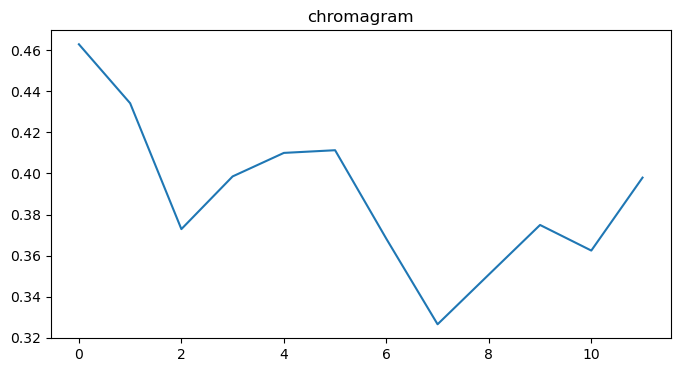

In [119]:
chromagram = extract_chromagram(dataframe.FilePath[3],show_plot=True)

### 3.2.2. Spectral Contrast

In [120]:
def extract_SC(audio_path:str, sr:float=48000,show_plot:bool=False, data:np.ndarray=None)->np.ndarray:
    audio= load_audio(audio_path) if data is None else data
    SCF = librosa.feature.spectral_contrast(y=audio, sr=sr)
    if show_plot:
        plt.figure(figsize=(8, 4))
        plt.plot(SCF.mean(axis=1))
        plt.title('Spectral Contrast')
        plt.grid()
    return SCF.mean(axis=1)  # Mean across time frames

(7,)

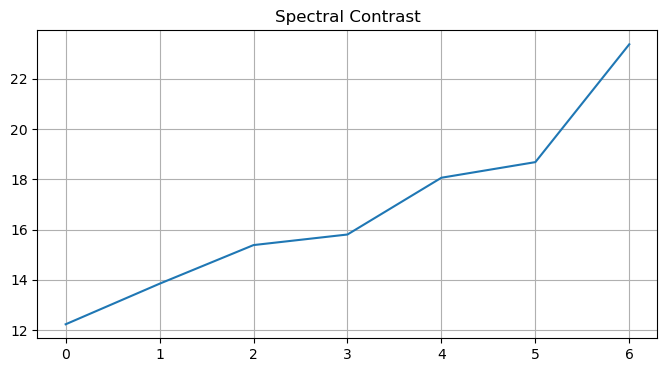

In [110]:
sc = extract_SC(dataframe.FilePath[3],show_plot=True) 
sc.shape

### 3.2.3 Tonnetz Representation

In [121]:
def extract_tonnetz(audio_path:str, sr:float=48000,show_plot:bool=False, data:np.ndarray=None)->np.ndarray:
    audio= load_audio(audio_path) if data is None else data
    # Compute Harmonic component first (necessary for Tonnetz)
    harmonic = librosa.effects.harmonic(audio)

    tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sr)
    if show_plot:
        plt.figure(figsize=(8, 4))
        plt.plot(tonnetz.mean(axis=1))
        plt.title('Tonnetz')
        plt.grid()
    return tonnetz.mean(axis=1)  # Mean across time frames

(6,)

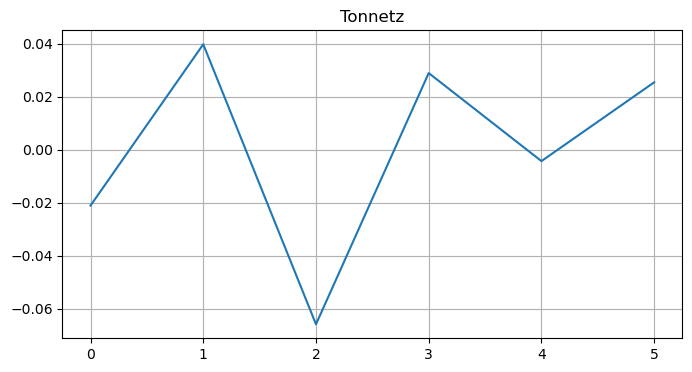

In [119]:
tonnetz = extract_tonnetz(dataframe.FilePath[3],show_plot=True)
tonnetz.shape

### 3.3 Prosodic Features (Pitch, Intensity, Duration)

In [25]:
def extract_prosodic(audio_path:str, sr:float=48000, data:np.ndarray = None) -> list:
    audio =load_audio(audio_path) if data is None else data
    # Pitch (F0)
    pitches = librosa.yin(audio, fmin=50, fmax=260)
    pitch_mean = pitches.mean()

    # Intensity (Energy)
    energy = np.sqrt(np.mean(audio**2))

    # Duration (Voiced regions)
    voiced_frames = librosa.effects.split(audio, top_db=35)
    duration = sum((v[1] - v[0]) for v in voiced_frames) / sr
    return [pitch_mean, energy, duration]


In [31]:
prosodic_features = extract_prosodic(dataframe.FilePath[3])

print(f"Pitch: {prosodic_features[0]:.2f} Hz")
print(f"Energy: {prosodic_features[1]:.2f}")
print(f"Duration: {prosodic_features[2]:.2f} seconds")

Pitch: 154.56 Hz
Energy: 0.05
Duration: 1.90 seconds


In [30]:
prosodic_features = extract_prosodic(dataframe.FilePath[300])

print(f"Pitch: {prosodic_features[0]:.2f} Hz")
print(f"Energy: {prosodic_features[1]:.2f}")
print(f"Duration: {prosodic_features[2]:.2f} seconds")

Pitch: 146.59 Hz
Energy: 0.00
Duration: 1.56 seconds


### 3.4 Features combination

In [120]:
def extract_features_from_dataset(dataset:pd.DataFrame, output_pickle:str):
    if "FilePath" not in dataset.columns:
        raise ValueError("Dataset must have a 'FilePath' column containing file paths.")

    data = []
    for file_path in dataset.FilePath:
            if file_path.endswith(".wav"):
                try:
                    mfcc = extract_mfcc(file_path)
                    logmel = extract_logmel(file_path)
                    prosodic = extract_prosodic(file_path)
                    # Combine features
                    features = np.hstack([mfcc, logmel, prosodic])
                    data.append(features)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    data.append(None)
                    continue
    dataset["Features"] = data    
    # Save to pickle
    os.makedirs(output_pickle, exist_ok=True)
    output_pickle = f"{output_pickle}/RAVDESS.pkl"
    dataset.to_pickle(output_pickle)
    print(f"Features extracted and saved to {output_pickle}")


In [122]:
import numpy as np
import librosa

def extract_features(path:str = None,data:np.ndarray = None)->np.ndarray:
    # Extract MFCCs
    mfcc = extract_mfcc(audio_path= path,data=data)
    
    # Extract log mel spectrogram
    logmel = extract_logmel(audio_path = path,data=data)
    
    # Extract prosodic features
    # parasodic = extract_prosodic(audio_path = path,data=data)

    # Extract chromagram
    chroma = extract_chromagram(audio_path = path,data=data)

    # Extract SC
    sc = extract_SC(audio_path = path,data=data)

    # Extract Tonnetz
    tonnetz = extract_tonnetz(audio_path = path,data=data)
    
    # Combine features
    features = np.hstack([mfcc, logmel, chroma, sc, tonnetz])
    
    return features

def get_features(path,augment=True):
    # Load the audio file
    data = load_audio(path)
    
    # Extract original features
    features = [extract_features(path,None)]
    
    if augment:
        # Apply augmentations
        augmentations = [
            lambda x: noise(x),  # Add noise
            lambda x: pitch(x, sampling_rate, pitch_factor=np.random.uniform(0.5, 1.5)),  # Random pitch shift
        ]

        for aug in augmentations:
            augmented_audio = aug(data)
            features.append(extract_features(data=augmented_audio))
        
        combined_features = extract_features(data=noise(augmentations[1](data)))
        features.append(combined_features)
        

    audio=np.vstack((features))
    
    return audio


In [125]:
from tqdm import tqdm

def extract_features_based_on_paper(dataset:pd.DataFrame, output_pickle:str):
    if "FilePath" not in dataset.columns:
        raise ValueError("Dataset must have a 'FilePath' column containing file paths.")

    X = []
    Y = []
    for file_path in tqdm(dataset.FilePath):
            if file_path.endswith(".wav"):
                try:
                    features = get_features(file_path)
                    for item in features:
                        X.append(item)
                        Y.append(extract_labels(file_path))
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    X.append(None)
                    Y.append(None)
                    continue
    DATA = pd.DataFrame(columns=["Feature","Emotion"])
    DATA['Feature'] = X
    DATA['Emotion'] = Y
    # Save to pickle
    os.makedirs(output_pickle, exist_ok=True)
    output_pickle = f"{output_pickle}/RAVDESS_PAPER_AUG.pkl"
    DATA.to_pickle(output_pickle)
    print(f"Features extracted and saved to {output_pickle}")

In [ ]:
sample1 = get_features(dataframe.FilePath[200],augment=False)
sample1.shape
DUMMY = pd.DataFrame(columns=["Feature","Emotion"])
features = []
labels = []
for item in sample1:
    features.append(item)
    labels.append(dataframe.Emotion[200])
sample2 = get_features(dataframe.FilePath[3],augment=False)
sample2.shape
for item in sample2:
    features.append(item)
    labels.append(dataframe.Emotion[3])
DUMMY["Feature"] = features
DUMMY["Emotion"] = labels

DUMMY.head()

,Feature,Emotion
0,"[-612.8169555664062, 58.136962890625, -15.0666...",surprised
1,"[-470.210693359375, 48.58982467651367, -8.5055...",angry


In [129]:
DUMMY.Feature[0].shape

(173,)

In [36]:
from tqdm import tqdm

def extract_features_and_augment_from_dataset(dataset:pd.DataFrame, output_pickle:str):
    if "FilePath" not in dataset.columns:
        raise ValueError("Dataset must have a 'FilePath' column containing file paths.")

    X = []
    Y = []
    for file_path in tqdm(dataset.FilePath):
            if file_path.endswith(".wav"):
                try:
                    features = get_features(file_path)
                    for item in features:
                        X.append(item)
                        Y.append(extract_labels(file_path))
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    X.append(None)
                    Y.append(None)
                    continue
    DATA = pd.DataFrame(columns=["Feature","Emotion"])
    DATA['Feature'] = X
    DATA['Emotion'] = Y
    # Save to pickle
    os.makedirs(output_pickle, exist_ok=True)
    output_pickle = f"{output_pickle}/RAVDESS_AUG.pkl"
    DATA.to_pickle(output_pickle)
    print(f"Features extracted and saved to {output_pickle}")

In [126]:
output_pickle_folder = "data/pickle/"
# extract_features_from_dataset(dataframe, output_pickle_folder)
# extract_features_and_augment_from_dataset(dataframe, output_pickle_folder)
extract_features_based_on_paper(dataframe, output_pickle_folder)

100%|██████████| 1440/1440 [54:51<00:00,  2.29s/it]    

Features extracted and saved to data/pickle//RAVDESS_PAPER_AUG.pkl


# 4. Feature space visualization

### 4.1 Normalization

In [99]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

pick_file = "data/pickle/RAVDESS_PAPER_AUG.pkl"

DATASET = pd.read_pickle(pick_file)

DATASET.head()

print(f"Original shape: {DATASET.Feature.shape}")
scaler = StandardScaler()

DATASET.Feature =  scaler.fit_transform(np.array(DATASET.Feature.tolist())).tolist()

print(f"Normalized shape: {DATASET.Feature.shape}")


Original shape: (5760,)
Normalized shape: (5760,)


In [117]:
5760/4

1440.0

In [100]:
DATASET.head()

,Feature,Emotion
0,"[-0.11988884194039733, 0.16381579625770532, -0...",5
1,"[1.6508868809474255, -1.4730673822200013, 0.31...",5
2,"[-0.27631848789357627, -0.045866100935326, -0....",5
3,"[1.6043405611041017, -1.5749144982998873, 0.28...",5
4,"[-0.254371015677113, 0.3425141769051871, -0.47...",6


### 4.2 k-means Clustring

#### 4.2.1 Compute PCA and then clustering

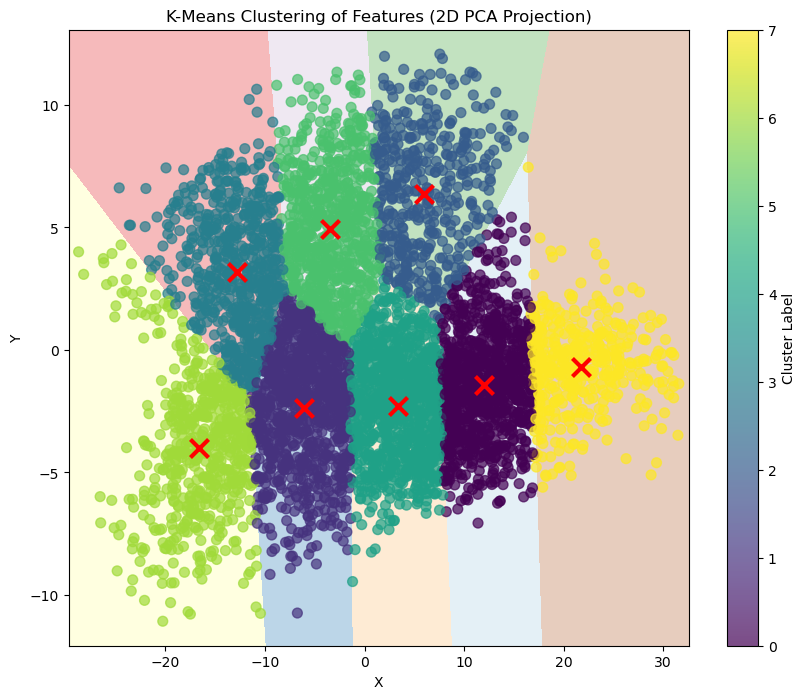

In [129]:
normalized_features = DATASET.Feature.tolist()
n_clusters = 8  

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features)

DATASET["PCA"] = reduced_features.tolist()

kmeans = KMeans(n_clusters=n_clusters,random_state=42,n_init=100,init='k-means++')
kmeans.fit(reduced_features)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.01 # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_features[:, 0].min() - 1, reduced_features[:, 0].max() + 1
y_min, y_max = reduced_features[:, 1].min() - 1, reduced_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Fit k-means to the normalized features
cluster_labels = kmeans.fit_predict(reduced_features)

DATASET["Cluster"] = cluster_labels

plt.figure(figsize=(10, 8))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower', alpha=0.3)
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50,alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")
plt.title("K-Means Clustering of Features (2D PCA Projection)")
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="r",
    zorder=10,
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

#### 4.2.2Compute the most frequent emotion in each cluster

In [130]:
cluster_to_emotion = DATASET.groupby('Cluster')['Emotion'].agg(lambda x: x.value_counts().idxmax())

DATASET["PredictedEmotion"] = DATASET.Cluster.map(cluster_to_emotion)


In [132]:
DATASET.head()

,Feature,Emotion,PCA,Cluster,PredictedEmotion
0,"[-0.11988884194039733, 0.16381579625770532, -0...",5,"[-1.6229182087268685, 5.283395501939001]",5,3
1,"[1.6508868809474255, -1.4730673822200013, 0.31...",5,"[18.612551619726283, -1.5720994172230407]",7,5
2,"[-0.27631848789357627, -0.045866100935326, -0....",5,"[-3.495477787111142, 6.395683421140001]",5,3
3,"[1.6043405611041017, -1.5749144982998873, 0.28...",5,"[18.10121850339221, -1.833104281468314]",7,5
4,"[-0.254371015677113, 0.3425141769051871, -0.47...",6,"[-3.352952238792313, 8.240461695628099]",5,3


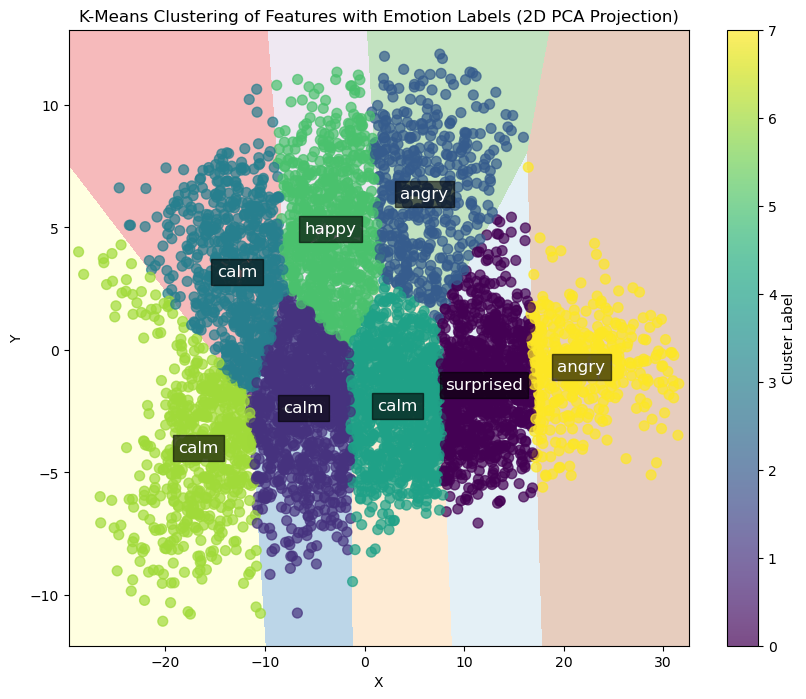

In [131]:
plt.figure(figsize=(10, 8))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower', alpha=0.3)
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50,alpha=0.7,)
plt.colorbar(scatter, label="Cluster Label")
# Add cluster names
cluster_names = list(cluster_to_emotion.values)  
for i, name in enumerate(cluster_names):
    plt.text(
        centroids[i, 0],  # X coordinate of the centroid
        centroids[i, 1],  # Y coordinate of the centroid
        label_to_emotion(name),  # The name of the cluster
        fontsize=12,
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        color='white',
        bbox=dict(facecolor='black', alpha=0.6)  # Background box for better visibility
    )
plt.title("K-Means Clustering of Features with Emotion Labels (2D PCA Projection)")

plt.xlabel("X")

plt.ylabel("Y")
plt.show()

# 5. Prepare Dataset and Train the Model

In [3]:
import torch
from torch.utils.data import  DataLoader, random_split
from torch import nn, optim
import numpy as np

pickle_file = "data/FeatureData/RAVDESS_AUG.pkl"

# Device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)


mps


### 5.1 Custom Dataset 

#### 5.1.1 Dataset class

#### 5.1.2 Normalization & transform function

In [4]:
from torchvision import transforms
from Dataset import AudioEmotionDataset


def normalization(tensor:torch.Tensor)->torch.Tensor:
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std

def to_tensor(array:np.ndarray)->torch.Tensor:
    return torch.from_numpy(array).float()

transforms = transforms.Compose(
    [
    to_tensor,
    normalization
    ]
)

dataset = AudioEmotionDataset(pickle_file, transform=transforms)

In [7]:
dataset.data

,Feature,Emotion
0,"[-691.0640869140625, 62.76224899291992, 5.2655...",8
1,"[-763.4278564453125, 73.52930450439453, -6.828...",8
2,"[-392.39908571820956, 22.435935405229028, 5.27...",5
3,"[-491.547949885941, 26.220532921670582, 14.163...",2
4,"[-457.3629150390625, 55.10616683959961, -11.44...",6
...,...,...
5755,"[-699.6422119140625, 65.30451202392578, -7.649...",3
5756,"[-712.6647140091634, 40.27172033402388, -0.458...",7
5757,"[-679.935546875, 63.998023986816406, -22.17689...",3
5758,"[-721.7535400390625, 64.59845733642578, 2.6441...",7


### 5.2 Split data to Train, Validation, Test 

In [118]:
train_size = int(0.7*dataset.__len__())
val_size = int(0.1*dataset.__len__())
test_size = dataset.__len__() - train_size - val_size

train_data, test_data, val_data  = random_split(dataset, [train_size, test_size,val_size])
len(train_data), len(test_data) , len(val_data)
# train_data.dataset.data.Emotion.value_counts()



(4031, 1153, 576)

In [131]:
torch.save(train_data, "data/pickle/TRAIN_SET.pth")
torch.save(test_data, "data/pickle/TEST_SET.pth")

### 5.3 DataLoader

In [6]:
batch_size = 32
train_data = torch.load("data/pickle/TRAIN_SET.pth")
test_data = torch.load("data/pickle/TEST_SET.pth")

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)



In [7]:
example_batch_feature, example_batch_label = next(iter(train_loader))

print(f"Batch inputs shape: {example_batch_feature[0].shape}")
print(f"Batch label shape: {example_batch_label[0].shape}")

Batch inputs shape: torch.Size([1, 173])
Batch label shape: torch.Size([])


In [8]:
example_batch_feature, example_batch_label = next(iter(train_loader))

example_batch_feature[0].shape , example_batch_label

(torch.Size([1, 173]),
 tensor([5, 0, 7, 4, 1, 4, 2, 3, 6, 2, 5, 6, 4, 6, 0, 7, 2, 7, 2, 4, 5, 1, 1, 2,
         3, 4, 6, 3, 4, 6, 6, 0]))

### 5.4 UNet model

In [28]:
# Train the model
import importlib
import models.UNet as UNetModel 
importlib.reload(UNetModel)

model = UNetModel.UNet(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001,weight_decay=1e-4) # L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.5, verbose=True)

train_losses_UNet,test_lossesUNet,train_accUnet,test_accUnet = UNetModel.train_model(model, train_loader, test_loader,scheduler, criterion, optimizer, device, num_epochs=150)


Epoch [10/150], TRLoss: 1.9045, TRAccuracy: 0.3632, TSLoss: 0.0613, TSAccuracy: 0.3964
Epoch [20/150], TRLoss: 1.7578, TRAccuracy: 0.5162, TSLoss: 0.0581, TSAccuracy: 0.4866
Epoch [30/150], TRLoss: 1.6083, TRAccuracy: 0.7477, TSLoss: 0.0557, TSAccuracy: 0.5846
Epoch [40/150], TRLoss: 1.4645, TRAccuracy: 0.8608, TSLoss: 0.0533, TSAccuracy: 0.6453
Epoch [50/150], TRLoss: 1.4031, TRAccuracy: 0.9015, TSLoss: 0.0527, TSAccuracy: 0.6626
Epoch [60/150], TRLoss: 1.3737, TRAccuracy: 0.9161, TSLoss: 0.0512, TSAccuracy: 0.7103
Epoch [70/150], TRLoss: 1.3466, TRAccuracy: 0.9586, TSLoss: 0.0516, TSAccuracy: 0.7173
Epoch [80/150], TRLoss: 1.3185, TRAccuracy: 0.9819, TSLoss: 0.0515, TSAccuracy: 0.7077
Epoch [90/150], TRLoss: 1.3054, TRAccuracy: 0.9859, TSLoss: 0.0509, TSAccuracy: 0.7355
Epoch [100/150], TRLoss: 1.2958, TRAccuracy: 0.9906, TSLoss: 0.0504, TSAccuracy: 0.7389
Epoch 00109: reducing learning rate of group 0 to 5.0000e-04.
Epoch [110/150], TRLoss: 1.2836, TRAccuracy: 0.9953, TSLoss: 0.0496

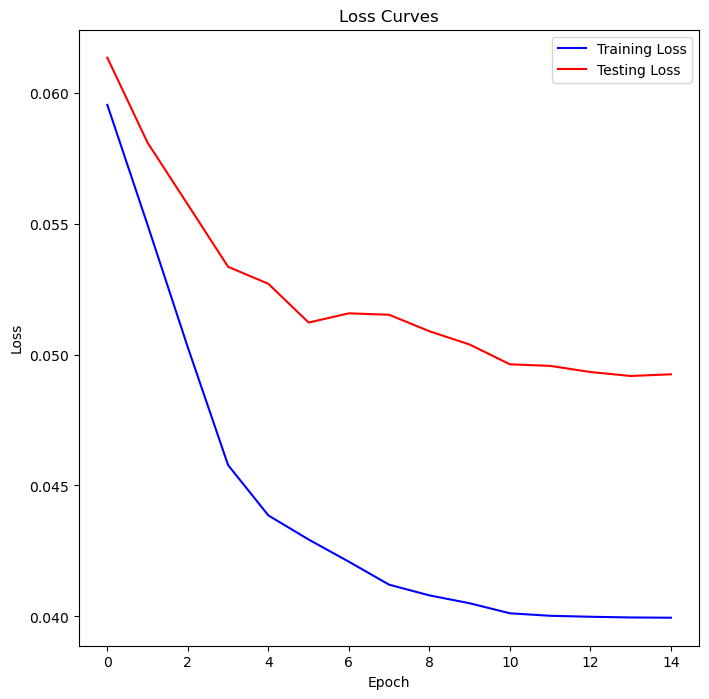

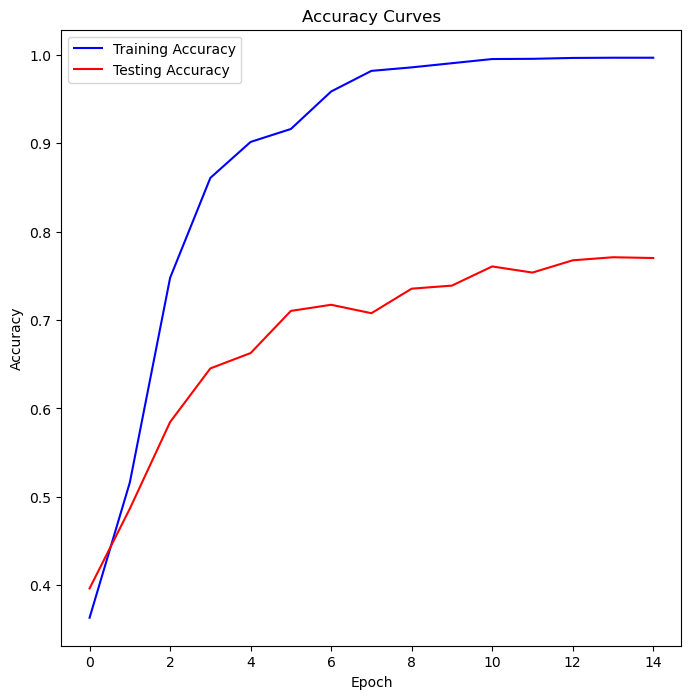

Classification Report:
              precision    recall  f1-score   support

     neutral       0.56      0.62      0.59        79
        calm       0.86      0.84      0.85       167
       happy       0.74      0.72      0.73       154
         sad       0.66      0.74      0.70       145
       angry       0.91      0.80      0.85       152
     fearful       0.78      0.80      0.79       143
     disgust       0.78      0.76      0.77       156
   surprised       0.80      0.80      0.80       157

    accuracy                           0.77      1153
   macro avg       0.76      0.76      0.76      1153
weighted avg       0.78      0.77      0.77      1153



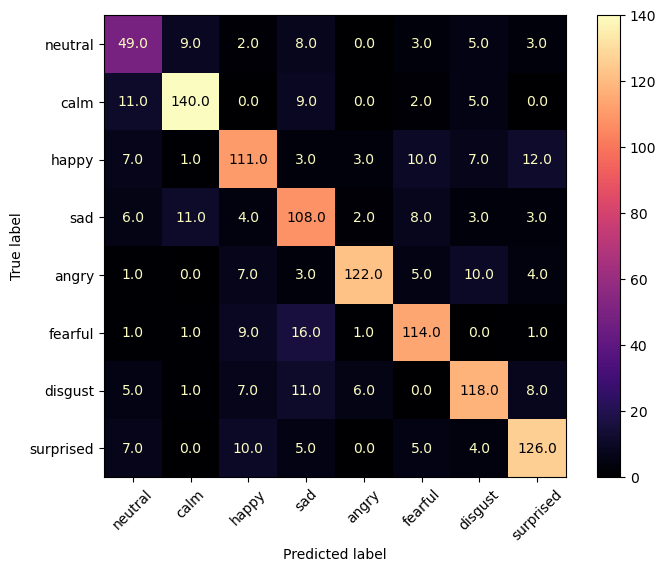

In [36]:
import importlib
import models.UNet as UNetModel 
importlib.reload(UNetModel)

#Plot the loss and accuracy curves
UNetModel.plot_curves(train_losses_UNet,test_lossesUNet,train_accUnet,test_accUnet)

# model's Metrics
UNetModel.get_all_metrics(model, test_loader, device)

In [132]:
torch.save(model.state_dict(), 'UNet.pth')


### 5.5 CNN Model

In [23]:
# Train the model
import importlib
import models.CNN as CNNModel

importlib.reload(CNNModel)

input_length = 173  # length of input sequences
num_classes = 8  # Number of classes in the dataset
model = CNNModel.CNN(input_length=input_length, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
train_losses,test_losses,train_acc,test_acc = CNNModel.train_model(model, train_loader, test_loader,criterion,optimizer, scheduler, device, num_epochs=100,
                                                                   use_early_stopping=False)

Epoch [10/100], TRLoss: 1.7852, TRAccuracy: 0.5907, TSLoss: 0.0574, TSAccuracy: 0.5776
Epoch [20/100], TRLoss: 1.6036, TRAccuracy: 0.7824, TSLoss: 0.0540, TSAccuracy: 0.6938
Epoch [30/100], TRLoss: 1.4715, TRAccuracy: 0.8993, TSLoss: 0.0507, TSAccuracy: 0.7788
Epoch [40/100], TRLoss: 1.3866, TRAccuracy: 0.9558, TSLoss: 0.0493, TSAccuracy: 0.8170
Epoch [50/100], TRLoss: 1.3536, TRAccuracy: 0.9762, TSLoss: 0.0479, TSAccuracy: 0.8543
Epoch [60/100], TRLoss: 1.3291, TRAccuracy: 0.9864, TSLoss: 0.0471, TSAccuracy: 0.8664
Epoch [70/100], TRLoss: 1.3188, TRAccuracy: 0.9893, TSLoss: 0.0464, TSAccuracy: 0.8742
Epoch [80/100], TRLoss: 1.3085, TRAccuracy: 0.9948, TSLoss: 0.0461, TSAccuracy: 0.8829
Epoch 00082: reducing learning rate of group 0 to 5.0000e-04.
Epoch [90/100], TRLoss: 1.2948, TRAccuracy: 0.9968, TSLoss: 0.0458, TSAccuracy: 0.8881
Epoch [100/100], TRLoss: 1.2928, TRAccuracy: 0.9975, TSLoss: 0.0455, TSAccuracy: 0.9081
Best_model Acc:0.9080659150043365


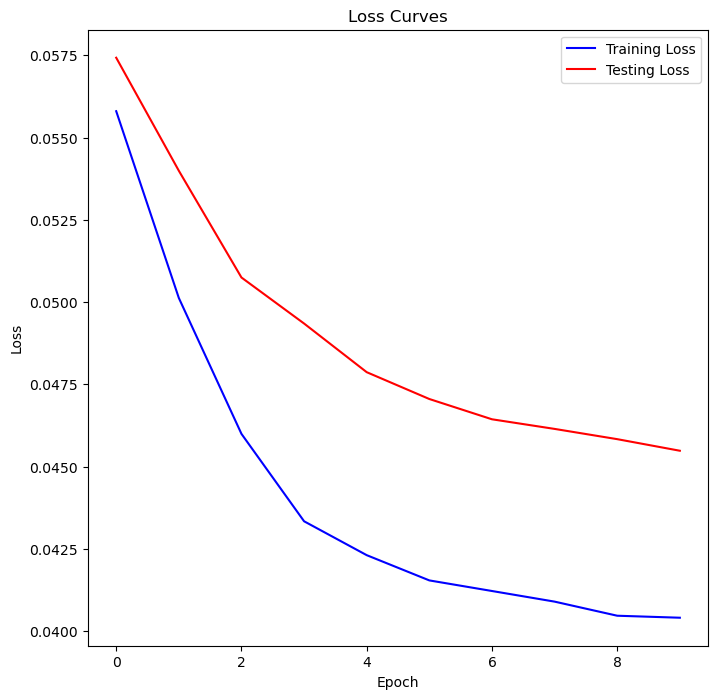

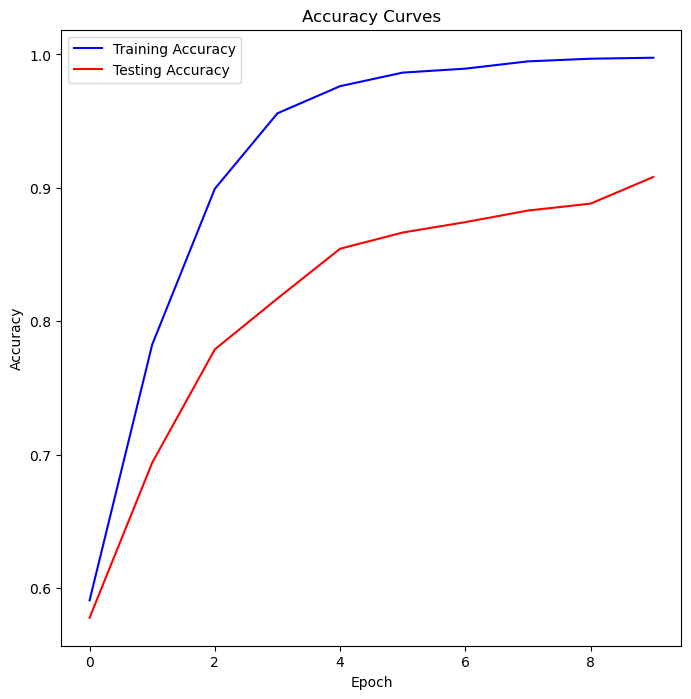

Classification Report:
              precision    recall  f1-score   support

     neutral       0.56      0.62      0.59        79
        calm       0.86      0.84      0.85       167
       happy       0.74      0.72      0.73       154
         sad       0.66      0.74      0.70       145
       angry       0.91      0.80      0.85       152
     fearful       0.78      0.80      0.79       143
     disgust       0.78      0.76      0.77       156
   surprised       0.80      0.80      0.80       157

    accuracy                           0.77      1153
   macro avg       0.76      0.76      0.76      1153
weighted avg       0.78      0.77      0.77      1153



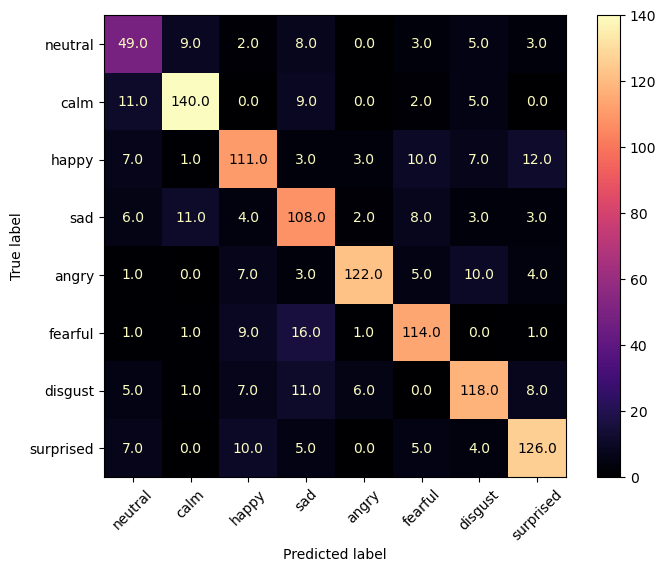

In [35]:
importlib.reload(CNNModel)

CNNModel.plot_curves(train_losses,test_losses,train_acc,test_acc)

CNNModel.get_all_metrics(model,test_loader,device)

In [ ]:
import torch
torch.save(model.state_dict(), 'Minh_CNN/BEST_MODEL.pth')